### Data Story - Question
How does one go about creating a data story? You have some pointers from the material you've just gone through, but they’re probably a bit on the abstract side when you’re just getting started. Also, storytelling is an art, so you have to get your imagination going. Here are some pointers to get those creative juices flowing. In the following sections we will work step-by-step to create your first Data Story.

1. Pick a dataset - ideally the dataset for your Capstone. If for some reason you want to do this on a different data set, you can find one on Mode Analytics or Google's public data sets directory, or pick another one you like from elsewhere.
1. Get going by asking the following questions and looking for the answers with some code and plots:
1. Can you count something interesting?
1. Can you find some trends (high, low, increase, decrease, anomalies)?
1. Can you make a bar plot or a histogram?
1. Can you compare two related quantities?
1. Can you make a scatterplot?
1. Can you make a time-series plot?

Having made these plots,

1. what are some insights you get from them?
1. Do you see any correlations? Is there a hypothesis you would like to investigate further?
1. What other questions do they lead you to ask?

By now you’ve asked a bunch of questions, and found some neat insights.

1. Is there an interesting narrative, a way of presenting the insights using text and plots from the above, that tells a compelling story?
1. As you work out this story, what are some other trends/relationships you think will make it more complete?

### Approach

#### Data-Set
For this assignment purpose, the dataset will be used from [Kaggle Competition](https://www.kaggle.com/c/avazu-ctr-prediction/). Mostlikely, the same challenge will be capstone project as well.

#### Database
The training data base is in access of **6Gb** when unzipped. For this exercise, the data in csv will be converted into sqlite database and sql queries will be used for exploration purpose. Please see **csv_to_sql.ipynb** notebook which converts csv into sqlite database. For this story notebook, the data-set is already converted into database format.

### What I am looking for?
This data-set contains data around an ad being clicked or not for the purpose of predicting Click-Through-Rate (CTR). For predicting CTR, the first step would be to workout the features impacting CTR. This exercise will pick a column of the data-set one by one and workout if a particular element in data-set affects CTR or not. This gives an insight into the data-set and helps with the modelling and co-relating the machine learning model to the data-set.

### Connect and Load Database

In [1]:
%pylab inline
import os
import pandas as pd
from sqlalchemy import create_engine # database connection
import matplotlib.pyplot as plt
import seaborn as sns

def _get_sqldb_url(relative_path):
    abs_path = os.path.abspath(relative_path)
    return ('sqlite:///' + abs_path)
    
disk_engine = create_engine(_get_sqldb_url('../capstone_project/data/train.db'))    
db_df = pd.read_sql_query('SELECT * FROM data LIMIT 3', disk_engine)
print (db_df.columns)
db_df.head()


Populating the interactive namespace from numpy and matplotlib
Index(['index', 'id', 'click', 'hour', 'C1', 'banner_pos', 'site_id',
       'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category',
       'device_id', 'device_ip', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21'],
      dtype='object')


,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1,1000009418151094273,0,2014-10-21 00:00:00.000000,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,2,15706,320,50,1722,0,35,-1,79
1,2,10000169349117863715,0,2014-10-21 00:00:00.000000,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15704,320,50,1722,0,35,100084,79
2,3,10000371904215119486,0,2014-10-21 00:00:00.000000,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,...,1,0,15704,320,50,1722,0,35,100084,79


### Exploration - 1: Click Through Rate (CTR)

As soon as someone starts playing with the data-set, the first question that comes in mind is - what is CTR for this data-set? From the data-set it appears that when one or more ads are clicked, the click_count column is more than 0 and when an ad is not clicked, the click_count is zero.

The ratio of total entries with postive click_count (click_cout > 0) to total entries in data-set will determine **CTR**.

In [2]:
clk_pos = pd.read_sql_query('SELECT COUNT (id) FROM data where click > 0', disk_engine)

In [3]:
clk_neg = pd.read_sql_query('SELECT COUNT (id) FROM data where click == 0', disk_engine)

In [4]:
clk_total = pd.read_sql_query('SELECT COUNT (id) FROM data', disk_engine)

In [5]:
s_rate = clk_pos.ix[0][0]/clk_total.ix[0][0]
f_rate = clk_neg.ix[0][0]/clk_total.ix[0][0]

In [6]:
print('The success rate (Click-Through-Rate) is {:.2%} and failure rate is {:.2%} for {} clicks!'.format(s_rate, f_rate, clk_total.ix[0][0]))

The success rate (Click-Through-Rate) is 16.98% and failure rate is 83.02% for 40428967 clicks!


### Exploration - 2: Click count per day of the week

In [7]:
query = "select "\
            " cast (strftime('%w', hour) as integer) as day_num, "\
            "case cast (strftime('%w', hour) as integer)  "\
            "when 0 then 'Sunday'  "\
            "when 1 then 'Monday'  "\
            "when 2 then 'Tuesday'  "\
            "when 3 then 'Wednesday'  "\
            "when 4 then 'Thursday'  "\
            "when 5 then 'Friday'  "\
            "else 'Saturday' end as day_of_week,  "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click > 0 "\
        "group by day_of_week "\
        "order by day_num"
        
clk_grp_by_day = pd.read_sql_query(query, disk_engine)

#### Plot: click_count per days of the week when click_count > 0

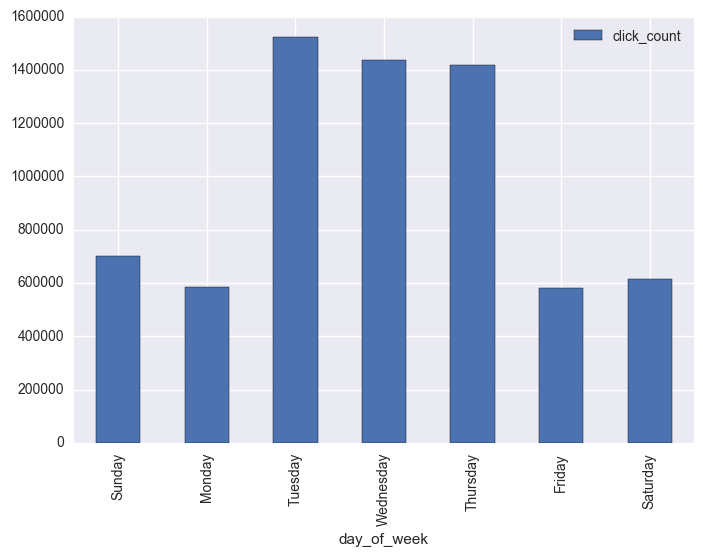

In [8]:
data_pos = clk_grp_by_day[['day_of_week', 'click_count']].set_index('day_of_week')
data_pos.plot(kind='bar')

From the graph above, the day of week matters for converting the clicks. It seems busier by 3x over the middle of the week (Tuesday, Wednesday, and Thursday). Tuesday seems the busiest of the lot!

#### Plot: click_count through per days of the week when click_count = 0

In [9]:
query = "select "\
            " cast (strftime('%w', hour) as integer) as day_num, "\
            "case cast (strftime('%w', hour) as integer)  "\
            "when 0 then 'Sunday'  "\
            "when 1 then 'Monday'  "\
            "when 2 then 'Tuesday'  "\
            "when 3 then 'Wednesday'  "\
            "when 4 then 'Thursday'  "\
            "when 5 then 'Friday'  "\
            "else 'Saturday' end as day_of_week,  "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click == 0 "\
        "group by day_of_week "\
        "order by day_num"
        
clk_grp_by_day_neg = pd.read_sql_query(query, disk_engine)

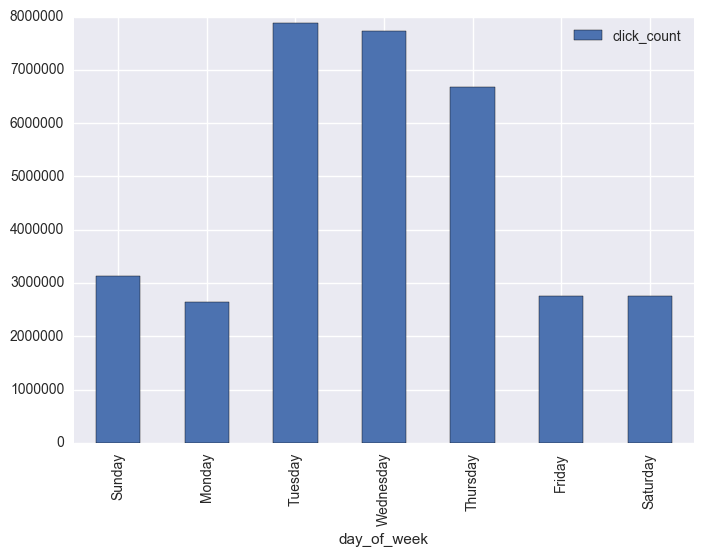

In [10]:
data_neg = clk_grp_by_day_neg[['day_of_week', 'click_count']].set_index('day_of_week')
data_neg.plot(kind='bar')

#### Plot: CTR per  days of the week

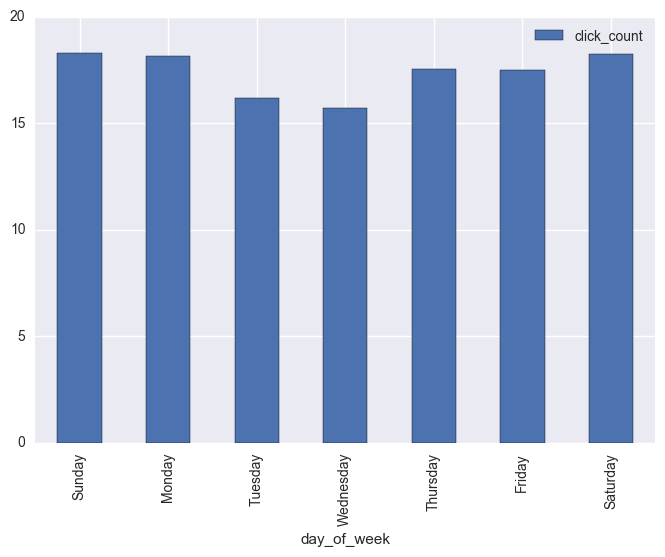

In [11]:
data_percent = data_pos * 100 / (data_neg + data_pos)
data_percent.plot(kind='bar')

In [12]:
print ('The Click Through Rate on Tuesday is {:0.2f}%.'.format(data_percent.ix['Tuesday'].iloc[0]))

The Click Through Rate on Tuesday is 16.18%.


#### Analysis:
On the busiest day of the week, the **CTR** is similar or slightly lower than **CTR** of the whole database, the day of the week is not really a feature affecting the **CTR**!

### Exploration - 3: Click count per hour of the day

#### Plot: click_count per banner_pos when click_count > 0

In [13]:
query = "select "\
            "strftime('%H', hour) as hour_of_the_day,  "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click > 0 "\
        "group by hour_of_the_day"

clk_grp_by_hour = pd.read_sql_query(query, disk_engine)

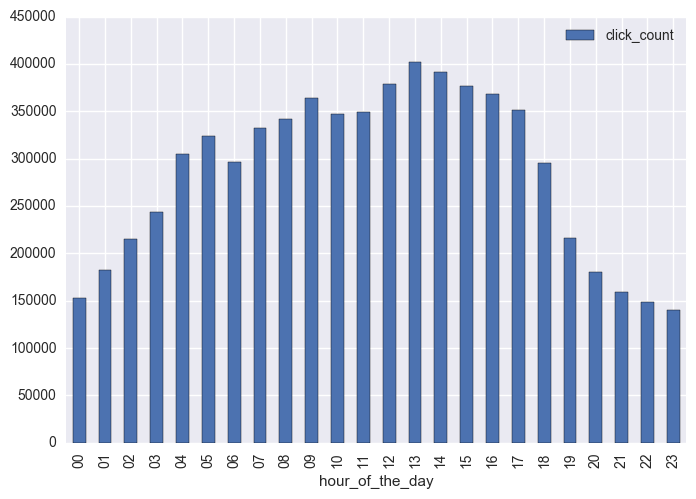

In [14]:
data = clk_grp_by_hour.set_index('hour_of_the_day')
data.plot(kind='bar')

#### Plot: click_count per banner_pos when click_count = 0

In [15]:
query = "select "\
            "strftime('%H', hour) as hour_of_the_day,  "\
            "COUNT (click) as no_click_count "\
        "from data "\
        "where click == 0 "\
        "group by hour_of_the_day"

clk_grp_by_hour_neg = pd.read_sql_query(query, disk_engine)

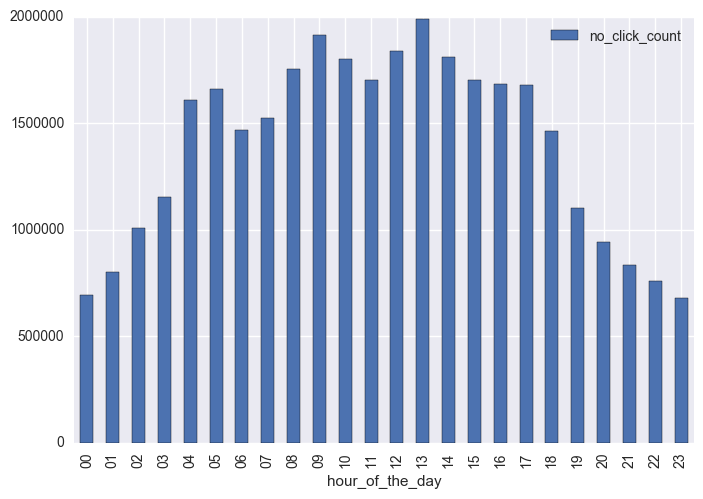

In [16]:
data = clk_grp_by_hour_neg.set_index('hour_of_the_day')
data.plot(kind='bar')

#### Plot: CTR per hour of the day

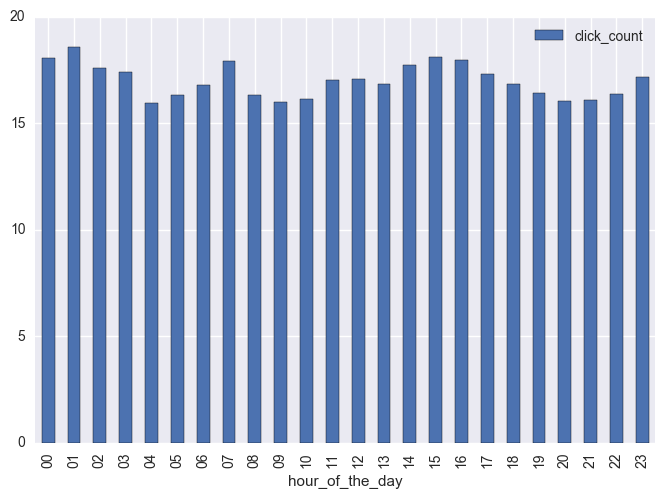

In [17]:
#data = clk_grp_by_hour.div(clk_grp_by_hour_neg.no_click_count)
data_pos = clk_grp_by_hour.set_index('hour_of_the_day')
data_neg = clk_grp_by_hour_neg.set_index('hour_of_the_day')
data_neg.rename(columns={'no_click_count': 'click_count'}, inplace=True)
data_percent = data_pos * 100 / (data_neg + data_pos)
data_percent.plot(kind='bar')

In [18]:
print ('The percentage of sucess rate through different hour of the day is {0:.2f}%.'.format(data_percent.mean().ix[0]))

The percentage of sucess rate through different hour of the day is 17.01%.


### Analysis:

Since the distribution and the mean success rate through out the day is the similar to CTR for the whole data-set, **the time of the day** is **not a feature** affecting **the CTR**.

### Exploration - 4: Is C1 a feature affecting CTR?

#### Plot: C1 values when click count > 0

In [19]:
query = "select "\
            "C1, "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click > 0 "\
        "group by C1 "\
        "order by 2"

clk_grp_by_C1 = pd.read_sql_query(query, disk_engine)

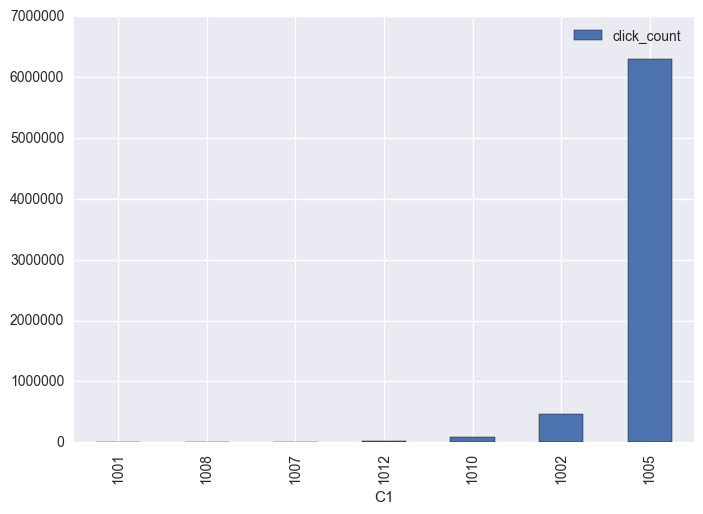

In [20]:
data = clk_grp_by_C1.set_index('C1')
data.plot(kind='bar')

In [21]:
query = "select "\
            "C1, "\
            "strftime('%H', hour) as hour_of_the_day,  "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click > 0 and C1 == 1005 "\
        "group by hour_of_the_day "\
        "order by hour_of_the_day"

clk_grp_C1_1005 = pd.read_sql_query(query, disk_engine)

#### Plot: C1 distribution by hour of the day for positive clicks when C1 == 1005

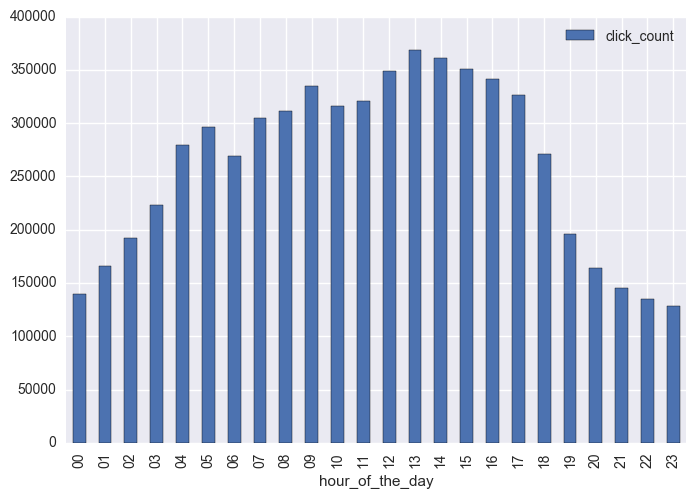

In [22]:
clk_grp_C1_1005
data = clk_grp_C1_1005[['hour_of_the_day', 'click_count']].set_index('hour_of_the_day')
data.plot(kind='bar')

#### Plot: C1 values when click_count = 0

In [23]:
query = "select "\
            "C1, "\
            "COUNT (click) as no_click_count "\
        "from data "\
        "where click = 0 "\
        "group by C1 "\
        "order by 2"

clk_grp_by_C1_neg = pd.read_sql_query(query, disk_engine)

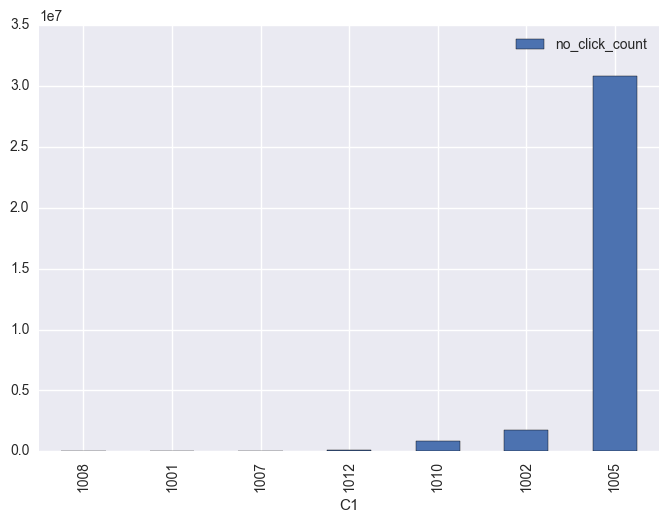

In [24]:
data = clk_grp_by_C1_neg.set_index('C1')
data.plot(kind='bar')

#### Analysis

In [25]:
click_miss = clk_grp_by_C1_neg[clk_grp_by_C1_neg.C1 == 1005].iloc[0][1]
click_hit = clk_grp_by_C1[clk_grp_by_C1.C1 == 1005].iloc[0][1]
ratio = click_hit / (click_hit + click_miss)

In [26]:
print ("Total entries with C1 == 1005: {}".format(click_hit + click_miss))
print ("Total entries with C1 != 1005: {}".format(clk_total.ix[0][0] - click_hit - click_miss))
print ("% entries with C1 == 1005: {:.2%}".format((click_hit + click_miss) / clk_total.ix[0][0]))
print ("Click-Through-Rate when C1 == 1005: {:.2%}".format(ratio))
print ("Click-Through-Rate for the whole data set: {:.2%}".format(s_rate))
print ("From the above data, it seems that C1 is not a feature affecting CTR")

Total entries with C1 == 1005: 37140632
Total entries with C1 != 1005: 3288335
% entries with C1 == 1005: 91.87%
Click-Through-Rate when C1 == 1005: 16.93%
Click-Through-Rate for the whole data set: 16.98%
From the above data, it seems that C1 is not a feature affecting CTR


### Exploration - 5: Is site_category a feature affecting the CTR?

In [27]:
query = "select "\
            "site_category, "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click > 0 "\
        "group by site_category "\
        "order by 1"

clk_grp_sg = pd.read_sql_query(query, disk_engine)

#### Plot: click_count per banner_pos when click_count > 0

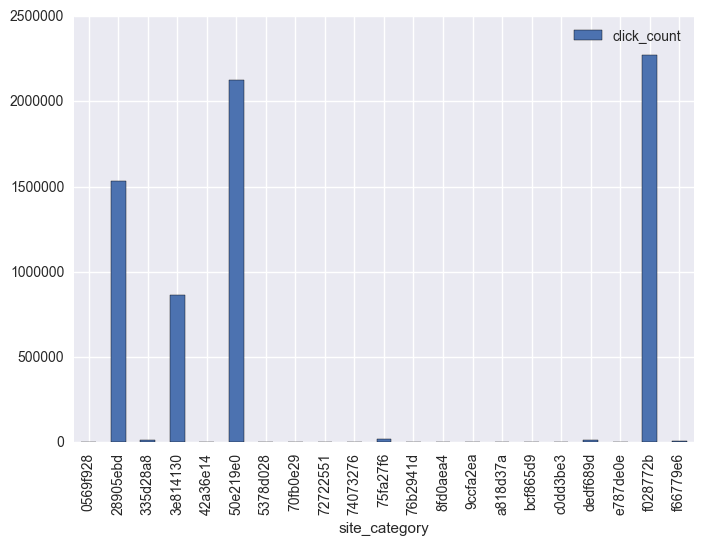

In [28]:
data_pos = clk_grp_sg.set_index('site_category')
data_pos.plot(kind='bar')

#### Plot: click_count per banner_pos when click_count = 0

In [29]:
query = "select "\
            "site_category, "\
            "COUNT (click) as click_count "\
        "from data "\
        "where click == 0 "\
        "group by site_category "\
        "order by 1"

clk_grp_sg_neg = pd.read_sql_query(query, disk_engine)

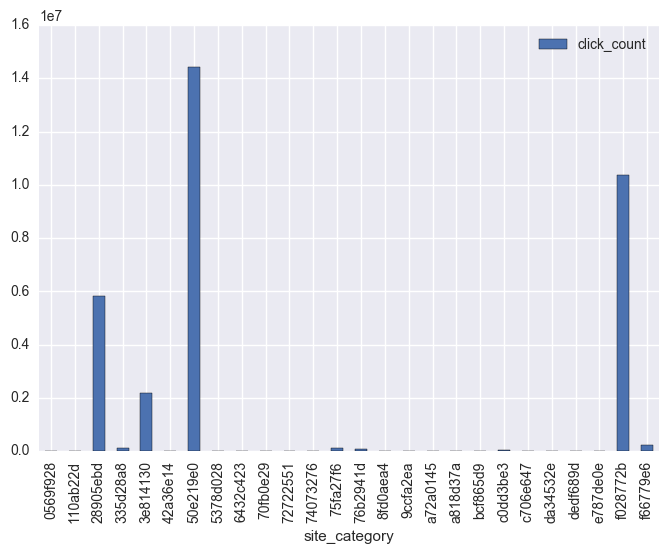

In [30]:
data_neg = clk_grp_sg_neg.set_index('site_category')
data_neg.plot(kind='bar')

#### Plot: CTR per site_category

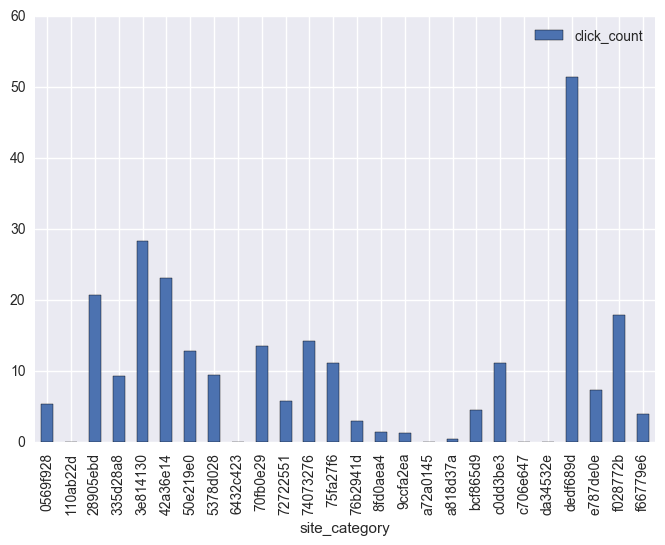

In [31]:
data_percent = data_pos * 100 / (data_neg + data_pos)
data_percent.plot(kind='bar')

#### Analysis

Clearly, from above chart, it can be observed that certain site categories are more successfull than the other. **Site Catrgory** can be a feature that can impact the **CTR**!

### Defining Some Generic Functions

From the above analysis, there is a pattern in accessing the queries. A couple of generic functions can be developed to make this analysis process a bit faster.

In [32]:
def _get_click_count_query(column_name, pos=True):
    query = "select "\
                + column_name + ",  "\
                "COUNT (click) as click_count "\
            "from data "
    if pos:
        query += "where click > 0 "
    else:
        query += "where click == 0 "
        
    query += "group by 1 order by 1"
    return query

def _data_percentage(data_pos, data_neg, plot=True):
    data_percent = data_pos * 100 / (data_neg + data_pos)
    if plot:
        data_percent.plot(kind='bar')
    return data_percent

### Exploration - 6: Is banner_pos a feature affecting the CTR?

In [33]:
query = _get_click_count_query('banner_pos')
clk_grp_pos = pd.read_sql_query(query, disk_engine)

#### Plot: click_count per banner_pos when click_count > 0

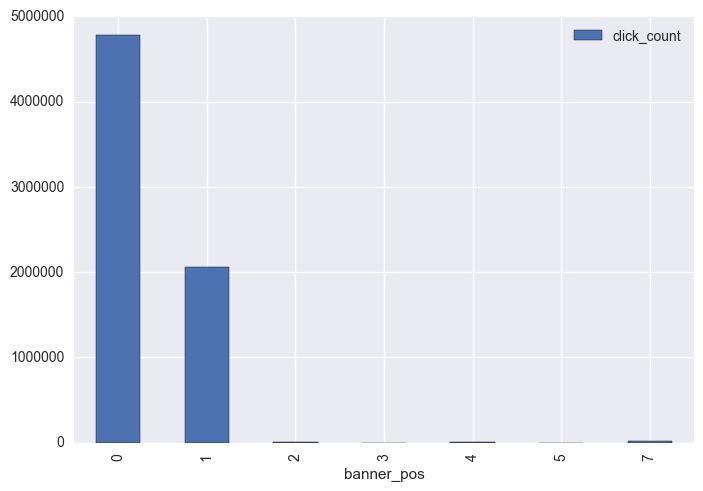

In [34]:
data_pos = clk_grp_pos.set_index('banner_pos')
data_pos.plot(kind='bar')

In [35]:
query = _get_click_count_query('banner_pos', pos=False)
clk_grp_neg = pd.read_sql_query(query, disk_engine)

#### Plot: click_count per banner_pos when click_count = 0

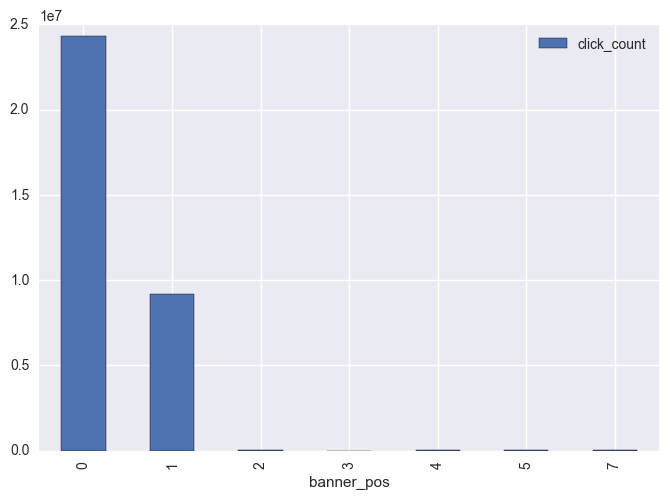

In [36]:
data_neg = clk_grp_neg.set_index('banner_pos')
data_neg.plot(kind='bar')

#### Plot: CTR per banner_pos

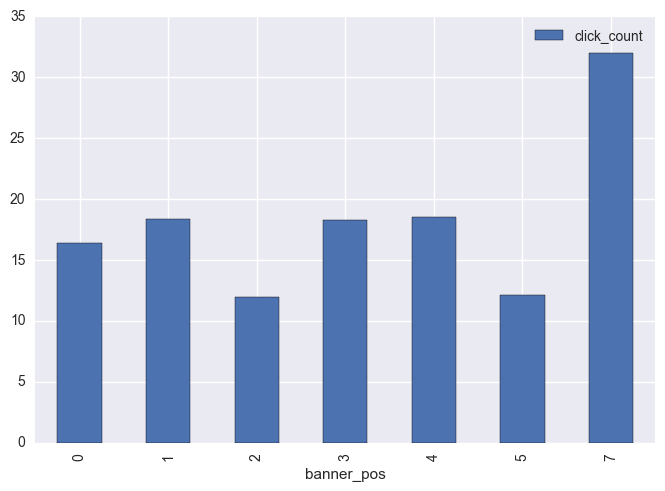

In [37]:
data_percent = _data_percentage(data_pos, data_neg, plot=True)

In [38]:
data_pos.ix[7][0] + data_neg.ix[7][0]

43577

#### Analysis
Since most of the ads are placed with banner_pos 0 and 1, and the CTR for these banner positions is similar to the whole data-set, banner_pos is **not a feature affecting** the **CTR**. The banner_pos 7 has twice as much success. However, it features only in **43577** rows which is a fraction of 40 millions+ rows.

### Exploraion - 7: Is app_category a feature affecting the CTR?

In [39]:
#features = ['app_category', 'device_id', 'device_ip', 'device_model', 'device_type',
#            'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
features = ['app_category']
features_pos = {}
features_neg = {}
features_percent = {}

for feature in features:
    clk_grp_pos = pd.read_sql_query(_get_click_count_query(feature, pos=True), disk_engine)
    clk_grp_neg = pd.read_sql_query(_get_click_count_query(feature, pos=False), disk_engine)
    features_pos[feature] = clk_grp_pos.set_index(feature)
    features_neg[feature] = clk_grp_neg.set_index(feature)
    features_percent[feature] = _data_percentage(features_pos[feature], features_neg[feature], plot=False)
    

#### Plot: click_count per app_category when click_count > 0

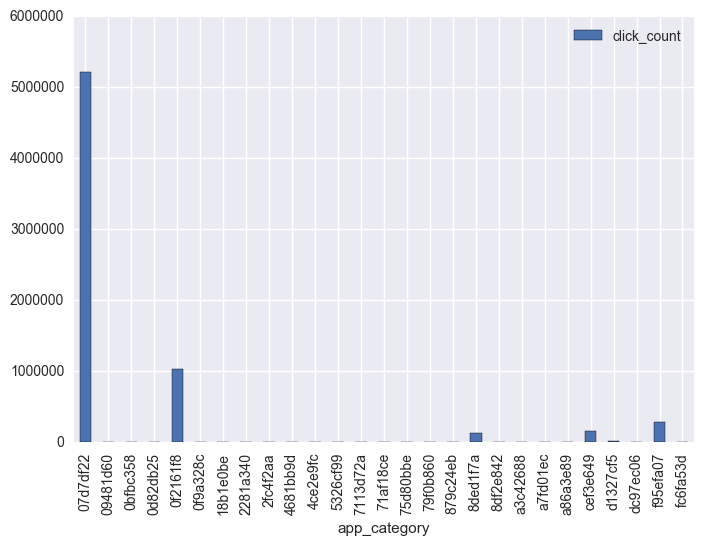

In [40]:
features_pos['app_category'].plot(kind='bar')

#### Plot: click_count per app_category when click_count = 0

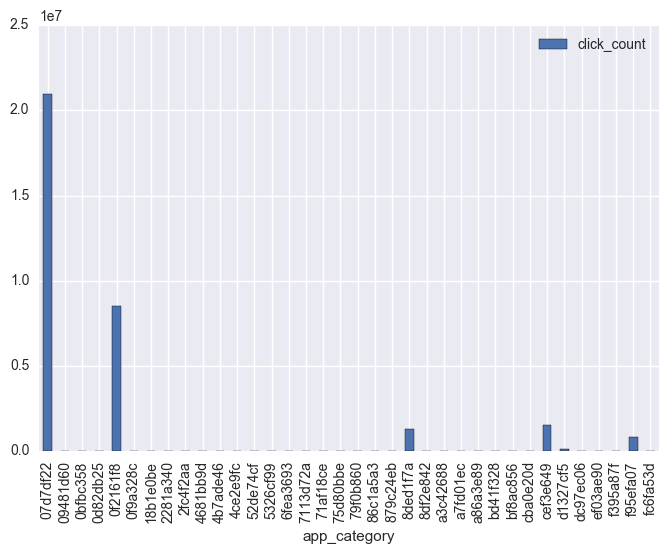

In [41]:
features_neg['app_category'].plot(kind='bar')

#### Plot: CTR per app_category

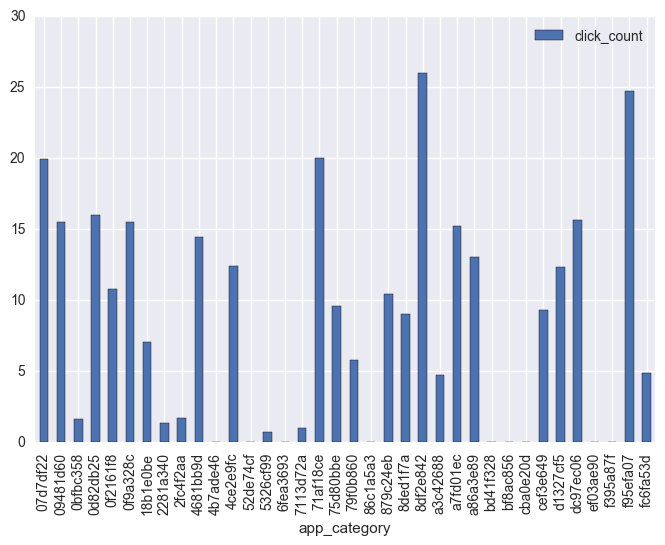

In [42]:
features_percent['app_category'].plot(kind='bar')

#### Analysis

The app_category plot is in a mix bag. Certain app_category does not have any positive click_count. They appear in table when click_count is zero but not when click_count is more than zero. Also, certain app_category sees higher CTR rate compared to other types of app_category. With these observations, it can be concluded that **app_catrgory** could be a feature affecting **CTR**.

### Furture Work

The other column types like device_type, device_conn_type and other coefficients could also be analysted in similar manner to see their trend on CTR. Also, click_count data could be zoomed in when click_count is not zero. A particular IP, device could have higher impact on CTR or they could be skewing its value.